# Transfer Learning


Call my drive 


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Load Data from drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
from google.colab.patches import cv2_imshow

#*******************************************************************************
# function to read images by spetail detection 
def read_images(data):
  lst_images = []
  for path in data:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (331, 331)) 

    lst_images.append(img)
    
  return lst_images

#******************************************************************************* 
# Load The Dataset
path_covid19 = glob("/content/gdrive/MyDrive/COVID_19/covid19*/*") 
lst_imgs_covid19 = read_images(path_covid19)

path_normal = glob("/content/gdrive/MyDrive/COVID_19/normal*/*")
lst_imgs_normal = read_images(path_normal)

print("The number of chest X-ray images have covid19 : ",len(lst_imgs_covid19))
print("The number of chest X-ray images normal       : ",len(lst_imgs_normal))
print("Done ...")


The number of chest X-ray images have covid19 :  121
The number of chest X-ray images normal       :  121
Done ...


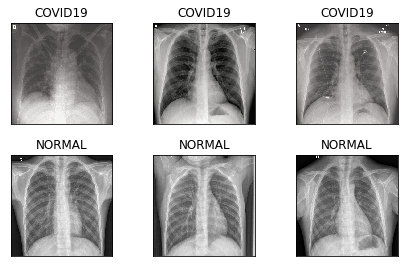

In [ ]:
# Display of some images
fig = plt.figure()
j = 0
for i in range(6):
  plt.subplot(2,3, i+1)
  plt.tight_layout()
  if i < 3 :    
    plt.imshow(lst_imgs_covid19[i], cmap="gray", interpolation="none")
    plt.title("COVID19")
  else:
    plt.imshow(lst_imgs_normal[j], cmap="gray", interpolation="none")
    plt.title("NORMAL")
    j = j + 1
  plt.xticks([])
  plt.yticks([])

In [ ]:
# Labels
labels_covid19 = [1] * len(lst_imgs_covid19)
labels_normal  = [0] * len(lst_imgs_normal)

# Scale the pixel intensities down to the [0,1] range by dividing them by 255.0 
# (this also converts them to floats).
X = lst_imgs_covid19 + lst_imgs_normal
y = labels_covid19   + labels_normal

X = np.asarray(X)
y = np.asarray(y)

X = X.astype("float32") 
X = X / 255.0

#*******************************************************************************
# shuffle the dataset
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

# Split data into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                test_size= 0.20, random_state=100)

print("X_train shape : ",X_train.shape, " y_train shape : ",y_train.shape)
print("X_test shape  : ",X_test.shape, " y_test shape : ",y_test.shape)


X_train shape :  (193, 331, 331, 3)  y_train shape :  (193,)
X_test shape  :  (49, 331, 331, 3)  y_test shape :  (49,)


# Creating The Model


In [ ]:
"""
Image Augmentation
We will use Image Augmentation to increase the number of dataset and train the model on different types 
of combination formed by rotation ,flipping of image so as to increase 
our model accuracy
"""
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip   = False,  
        shear_range=0.1
)

datagen.fit(X_train)

print("Done ...")


Done ...


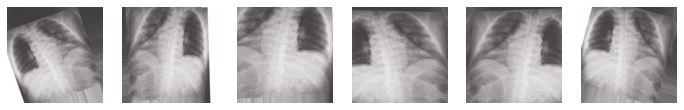

In [ ]:
# Plots various images created by the ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show

image = cv2.imread("/content/0.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (331, 331)) 

# Creating a dataset which contains just one image.
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

image_iterator = datagen.flow(images)

# Plot the images given by the iterator
fig, rows = subplots(nrows=1, ncols=6, figsize=(12,8))
for row in rows:
  row.imshow(image_iterator.next()[0].astype("int"))
  row.axis("off")
show()

# This is just one image but with different forms

In [ ]:
# Feature extraction
# NASNetLarge img(331,331)
feature_model = keras.applications.NASNetLarge(weights="imagenet", include_top=False)

features = feature_model.predict(X_train)
print(features.shape)
print(features[0].flatten().shape)


343621632/343610240 [==============================] - 4s 0us/step
(193, 11, 11, 4032)
(487872,)


In [ ]:
# Creating the model using the Sequential API
# If i use spectial shape 
# input_tensor = keras.layers.Input(shape=(224, 224,3))

# NASNetLarge img(331,331)
base_model = keras.applications.NASNetLarge(weights="imagenet", include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(avg)

model = keras.Model(inputs=base_model.input, outputs=output)

# The model’s summary() method displays all the model’s layers
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

In [ ]:
EPOCHS = 50
BS     = 32
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# Freeze the weights of the pretrained layers
for layer in model.layers[:-2]:
    layer.trainable = False

# Compiling the model
# Will use Adam Because it is speed and good
optimizer = keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# Will use loss "binary_crossentropy" because our brediction is binary classification 
model.compile(loss="binary_crossentropy", optimizer= optimizer, metrics=["accuracy"])

# Training the model
history = model.fit(datagen.flow(X_train,y_train, batch_size = BS), 
                    steps_per_epoch=len(X_train) // BS,
                    epochs= 5,  
                    validation_data= datagen.flow(X_test, y_test))

print("-----------------------------------------------------------------------")
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

# Allow certain layers to participate in the training process
for layer in model.layers[-2:]:
    layer.trainable = True

# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
model.compile(loss="binary_crossentropy", optimizer= optimizer, metrics=["accuracy"])

# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.0002, patience=2,
                                      monitor="val_accuracy", min_lr=0.000001)

# Interrupts training when it measures no progress on the validation set
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, monitor = "val_loss",
                                                  restore_best_weights=True)

# Training the model
history = model.fit(datagen.flow(X_train,y_train, batch_size = BS), 
                    steps_per_epoch=len(X_train) // BS,
                    epochs= EPOCHS,  
                    validation_data= datagen.flow(X_test, y_test),  
                    callbacks=[lr_scheduler, early_stopping_cb] )


Epoch 1/5
6/6 [==============================] - 46s 4s/step - loss: 0.5553 - accuracy: 0.6398 - val_loss: 0.2448 - val_accuracy: 0.9184
Epoch 2/5
6/6 [==============================] - 15s 3s/step - loss: 0.2673 - accuracy: 0.8758 - val_loss: 0.1365 - val_accuracy: 0.9592
Epoch 3/5
6/6 [==============================] - 17s 3s/step - loss: 0.2053 - accuracy: 0.9010 - val_loss: 0.1098 - val_accuracy: 0.9592
Epoch 4/5
6/6 [==============================] - 15s 3s/step - loss: 0.1940 - accuracy: 0.9193 - val_loss: 0.1299 - val_accuracy: 0.9388
Epoch 5/5
6/6 [==============================] - 16s 3s/step - loss: 0.1413 - accuracy: 0.9441 - val_loss: 0.0616 - val_accuracy: 1.0000
-----------------------------------------------------------------------
Epoch 1/50
6/6 [==============================] - 45s 4s/step - loss: 0.1393 - accuracy: 0.9441 - val_loss: 0.1518 - val_accuracy: 0.9388 - lr: 0.0050
Epoch 2/50
6/6 [==============================] - 18s 3s/step - loss: 0.1940 - accuracy: 0.9

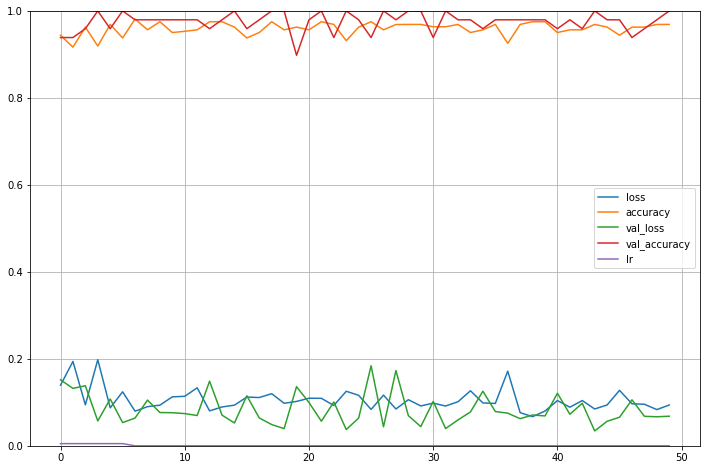

2/2 [==============================] - 9s 1s/step - loss: 0.0417 - accuracy: 0.9796
Loss     :  0.04173586145043373
accuracy :  0.9795918464660645


In [ ]:
# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])


Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.96      0.98        24

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49

Confusion matrix : 



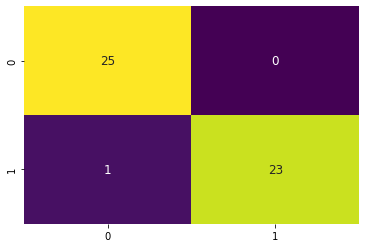

Normalized confusion matrix : 



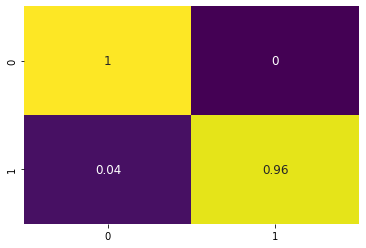

In [ ]:
# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32").tolist()

class_names = ["0", "1"]

# Compute classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification report : \n",classification_report(y_test, y_pred, target_names = class_names))

# Function to draw confusion matrix
import seaborn as sns
def draw_confusion_matrix(true, preds, normalize=None):
  # Compute confusion matrix
  conf_matx = confusion_matrix(true, preds, normalize = normalize)
  conf_matx = np.round(conf_matx, 2)
  # print(conf_matx)

  # plt.subplots(figsize=(14,8))
  sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12},fmt="g", cbar=False, cmap="viridis")
  plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(y_test, y_pred)

print("Normalized confusion matrix : \n")
draw_confusion_matrix(y_test, y_pred,"true")

# Make predictions
# predicted = model.predict(X_new)


In [ ]:
# Save model
model.save("/content/gdrive/MyDrive/My_models/chestXray_covid19_model.h5")
print("Done ...")


# Inference By Using Gradio

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 24.8 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 213 kB 75.8 MB/s 
     |████████████████████████████████| 106 kB 69.4 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 272 kB 74.4 MB/s 
     |████████████████████████████████| 2.3 MB 50.5 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 80 kB 9.7 MB/s 
     |████████████████████████████████| 68 kB 6.9 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 856 kB 62.3 MB/s 
     |████████████████████████████████| 593 kB 6

In [ ]:
# Loading the model
from tensorflow import keras
my_model = keras.models.load_model("/content/gdrive/MyDrive/My_models/chestXray_covid19_model.h5")
print("Done ...")


Done ...


In [ ]:
# https://www.gradio.app/ml_examples

import tensorflow as tf
from tensorflow import keras
import numpy as np
import gradio as gr
import requests
#from PIL import Image
import cv2

def inference(img):
    labels =["Covid19","Normal"]
    H,W,C = 331,331,3
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H, W)) 
    img = np.array(img)
    img = img.astype("float32")/255.0
    img = img.reshape(1,H,W,C)
    pred = my_model.predict(img).flatten()
    prediction = [pred[0], 1-pred[0]]
    dictionary = dict(zip(labels, map(float, prediction)))
    return dictionary


nbr_top_classes = 2
gr.Interface(fn=inference, 
             inputs=gr.inputs.Image(), 
             outputs=gr.outputs.Label(num_top_classes=nbr_top_classes),
             theme="darkdefault"
             ).launch(share=True) #, debug=True Use in Colab


/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://758bccdeaf4df701.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f7f62be8c90>,
 'http://127.0.0.1:7860/',
 'https://758bccdeaf4df701.gradio.app')